In [90]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [41]:
df_credits = pd.read_csv("tmdb_5000_credits.csv")
df_movies = pd.read_csv("tmdb_5000_movies.csv")

In [42]:
df_movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [43]:
df_credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [44]:
selected_columns = ['budget', 'genres', 'original_language', 'original_title',
                    'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime']


In [45]:
df_movies = df_movies[selected_columns]

In [46]:
# Defining the helper function to extract genres
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        primary_genre = genres_list[0]['name'] if len(genres_list) > 0 else None
        secondary_genre = genres_list[1]['name'] if len(genres_list) > 1 else None
        tertiary_genre = genres_list[2]['name'] if len(genres_list) > 2 else None
        return primary_genre, secondary_genre, tertiary_genre
    except (ValueError, SyntaxError):
        return None, None, None

In [47]:
# Applying the function to extract genres
df_movies[['primary_genre', 'secondary_genre', 'tertiary_genre']] = df_movies['genres'].apply(lambda x: pd.Series(extract_genres(x)))

# Dropping the original 'genres' column
df_movies = df_movies.drop(columns=['genres'])

# Previewing the dataset after handling 'genres' column
df_movies.head()

,budget,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,primary_genre,secondary_genre,tertiary_genre
0,237000000,en,Avatar,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,Action,Adventure,Fantasy
1,300000000,en,Pirates of the Caribbean: At World's End,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,Adventure,Fantasy,Action
2,245000000,en,Spectre,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,Action,Adventure,Crime
3,250000000,en,The Dark Knight Rises,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,Action,Crime,Drama
4,260000000,en,John Carter,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,Action,Adventure,Science Fiction


In [48]:
# Defining the helper function to handle unexpected values and extract production companies information
def extract_production_companies(prod_comp_str):
    try:
        prod_comp_list = ast.literal_eval(prod_comp_str)
        if not prod_comp_list or not isinstance(prod_comp_list, list):
            return None, 0
        primary_prod_comp = prod_comp_list[0]['name'] if len(prod_comp_list) > 0 else None
        num_prod_companies = len(prod_comp_list)
        return primary_prod_comp, num_prod_companies
    except (ValueError, SyntaxError):
        return None, 0

In [49]:
# Applying the function to extract production companies information
df_movies[['primary_production_company', 'num_production_companies']] = df_movies['production_companies'].apply(lambda x: pd.Series(extract_production_companies(x)))

In [50]:
# Defining the helper function to handle unexpected values and extract production countries information
def extract_production_countries(prod_country_str):
    try:
        prod_country_list = ast.literal_eval(prod_country_str)
        if not prod_country_list or not isinstance(prod_country_list, list):
            return None, 0
        primary_prod_country = prod_country_list[0]['iso_3166_1'] if len(prod_country_list) > 0 else None
        num_prod_countries = len(prod_country_list)
        return primary_prod_country, num_prod_countries
    except (ValueError, SyntaxError):
        return None, 0

In [51]:
# Applying the function to extract production countries information
df_movies[['primary_production_country', 'num_production_countries']] = df_movies['production_countries'].apply(lambda x: pd.Series(extract_production_countries(x)))

# Dropping the original 'production_companies' and 'production_countries' columns
df_movies = df_movies.drop(columns=['production_companies', 'production_countries'])

# Previewing the dataset after handling 'production_companies' and 'production_countries' columns
df_movies.head()

,budget,original_language,original_title,release_date,revenue,runtime,primary_genre,secondary_genre,tertiary_genre,primary_production_company,num_production_companies,primary_production_country,num_production_countries
0,237000000,en,Avatar,2009-12-10,2787965087,162.0,Action,Adventure,Fantasy,Ingenious Film Partners,4.0,US,2.0
1,300000000,en,Pirates of the Caribbean: At World's End,2007-05-19,961000000,169.0,Adventure,Fantasy,Action,Walt Disney Pictures,3.0,US,1.0
2,245000000,en,Spectre,2015-10-26,880674609,148.0,Action,Adventure,Crime,Columbia Pictures,3.0,GB,2.0
3,250000000,en,The Dark Knight Rises,2012-07-16,1084939099,165.0,Action,Crime,Drama,Legendary Pictures,4.0,US,1.0
4,260000000,en,John Carter,2012-03-07,284139100,132.0,Action,Adventure,Science Fiction,Walt Disney Pictures,1.0,US,1.0


In [52]:
# Converting 'budget' to numeric
df_movies['budget'] = pd.to_numeric(df_movies['budget'], errors='coerce')

# Converting 'release_date' to datetime
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extracting 'year' and 'month' from 'release_date'
df_movies['release_year'] = df_movies['release_date'].dt.year
df_movies['release_month'] = df_movies['release_date'].dt.month

In [53]:
# Dropping the original 'release_date' column
df_movies = df_movies.drop(columns=['release_date'])

# Handling missing values by filling them with appropriate placeholders or zeros
df_movies['primary_genre'].fillna('Unknown', inplace=True)
df_movies['secondary_genre'].fillna('Unknown', inplace=True)
df_movies['tertiary_genre'].fillna('Unknown', inplace=True)
df_movies['primary_production_company'].fillna('Unknown', inplace=True)
df_movies['primary_production_country'].fillna('Unknown', inplace=True)
df_movies[['budget', 'revenue', 'runtime', 'num_production_companies', 'num_production_countries', 'release_year', 'release_month']] = df_movies[['budget', 'revenue', 'runtime', 'num_production_companies', 'num_production_countries', 'release_year', 'release_month']].fillna(0)

In [54]:
df_movies.head()

,budget,original_language,original_title,revenue,runtime,primary_genre,secondary_genre,tertiary_genre,primary_production_company,num_production_companies,primary_production_country,num_production_countries,release_year,release_month
0,237000000,en,Avatar,2787965087,162.0,Action,Adventure,Fantasy,Ingenious Film Partners,4.0,US,2.0,2009.0,12.0
1,300000000,en,Pirates of the Caribbean: At World's End,961000000,169.0,Adventure,Fantasy,Action,Walt Disney Pictures,3.0,US,1.0,2007.0,5.0
2,245000000,en,Spectre,880674609,148.0,Action,Adventure,Crime,Columbia Pictures,3.0,GB,2.0,2015.0,10.0
3,250000000,en,The Dark Knight Rises,1084939099,165.0,Action,Crime,Drama,Legendary Pictures,4.0,US,1.0,2012.0,7.0
4,260000000,en,John Carter,284139100,132.0,Action,Adventure,Science Fiction,Walt Disney Pictures,1.0,US,1.0,2012.0,3.0


In [55]:
# Dropping the rows with budget = 0
df_movies = df_movies[df_movies['budget'] != 0].reset_index(drop=True)

# Checking the shape of the dataset after dropping rows with budget = 0
print(df_movies.shape)

# Setting 'original_title' as the index
df_movies.set_index('original_title', inplace=True)

(3766, 14)


In [56]:
# Creating the 'profitable' column
df_movies['profitable'] = df_movies.revenue > df_movies.budget
df_movies['profitable'] = df_movies['profitable'].astype(int)
df_movies["profitable"].value_counts() # Printing the types of Value and their Count in the 'profitable' column 

profitable
1    2438
0    1328
Name: count, dtype: int64

In [57]:
# One-Hot Encoding for Categorical Variables
categorical_columns = ['primary_genre', 'secondary_genre', 'tertiary_genre', 'primary_production_company', 
                       'primary_production_country', 'original_language']

In [58]:
df_movies_encoded = pd.get_dummies(df_movies, columns=categorical_columns, drop_first=True)

In [59]:
# Previewing the dataset after one-hot encoding
df_movies_encoded.head()

,budget,revenue,runtime,num_production_companies,num_production_countries,release_year,release_month,profitable,primary_genre_Adventure,primary_genre_Animation,...,original_language_pt,original_language_ro,original_language_ru,original_language_sv,original_language_te,original_language_th,original_language_tr,original_language_vi,original_language_xx,original_language_zh
original_title,,,,,,,,,,,,,,,,,,,,,
Avatar,237000000,2787965087,162.0,4.0,2.0,2009.0,12.0,1,False,False,...,False,False,False,False,False,False,False,False,False,False
Pirates of the Caribbean: At World's End,300000000,961000000,169.0,3.0,1.0,2007.0,5.0,1,True,False,...,False,False,False,False,False,False,False,False,False,False
Spectre,245000000,880674609,148.0,3.0,2.0,2015.0,10.0,1,False,False,...,False,False,False,False,False,False,False,False,False,False
The Dark Knight Rises,250000000,1084939099,165.0,4.0,1.0,2012.0,7.0,1,False,False,...,False,False,False,False,False,False,False,False,False,False
John Carter,260000000,284139100,132.0,1.0,1.0,2012.0,3.0,1,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
# Defining the features (X) and the target (y)
X = df_movies_encoded.drop(columns=['revenue'])
y = df_movies_encoded['revenue']

In [61]:
# Splitting the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
# Building a Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [63]:
# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

In [64]:
# Calculating the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

mae

74219474.51306257

In [65]:
# Excluding specified columns
df_movies_cleaned = df_movies.drop(columns=['original_language', 'secondary_genre', 'tertiary_genre', 'primary_production_company', 'primary_production_country'])

# Viewing the first few rows of the modified dataset
df_movies_cleaned.head()

,budget,revenue,runtime,primary_genre,num_production_companies,num_production_countries,release_year,release_month,profitable
original_title,,,,,,,,,
Avatar,237000000,2787965087,162.0,Action,4.0,2.0,2009.0,12.0,1
Pirates of the Caribbean: At World's End,300000000,961000000,169.0,Adventure,3.0,1.0,2007.0,5.0,1
Spectre,245000000,880674609,148.0,Action,3.0,2.0,2015.0,10.0,1
The Dark Knight Rises,250000000,1084939099,165.0,Action,4.0,1.0,2012.0,7.0,1
John Carter,260000000,284139100,132.0,Action,1.0,1.0,2012.0,3.0,1


In [66]:
# One-Hot Encoding for 'primary_genre'
df_movies_cleaned_encoded = pd.get_dummies(df_movies_cleaned, columns=['primary_genre'], drop_first=True)

In [67]:
# Defining the features (X) and the target (y) again
X = df_movies_cleaned_encoded.drop(columns=['revenue'])
y = df_movies_cleaned_encoded['revenue']

In [68]:
# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
# Building a Linear Regression Model again
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

# Calculating the Mean Absolute Error (MAE) again
mae = mean_absolute_error(y_test, y_pred)

mae

67313849.72174156

In [70]:
# Defining the features (X) and the target (y)
X = df_movies_encoded.drop(columns=['revenue'])
y = df_movies_encoded['revenue']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

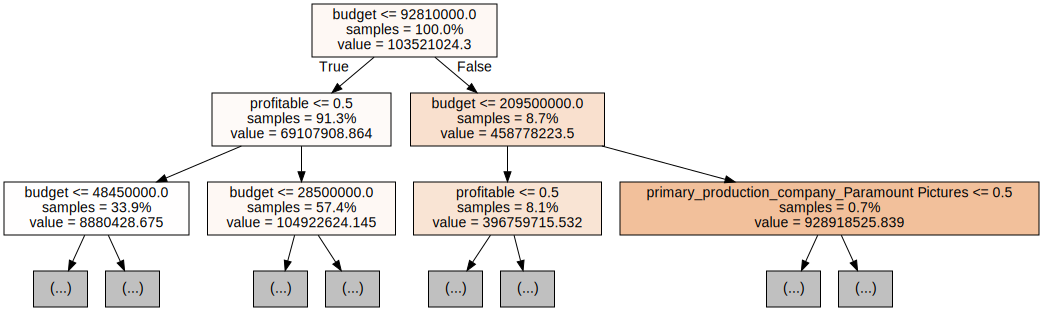

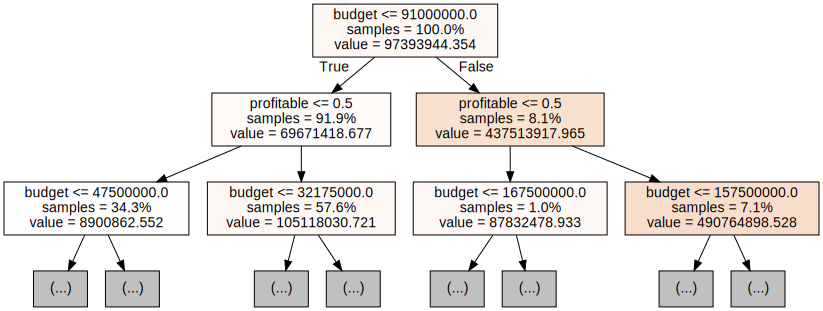

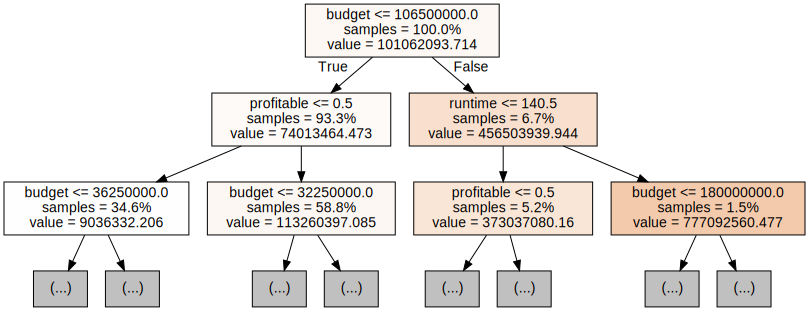

In [73]:
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [74]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.5930873345241838e+16
R^2 Score: 0.6295729333099757


In [79]:
regression_target = 'revenue'
classification_target = 'profitable'
regression_outcome = df_movies_encoded[regression_target]
classification_outcome = df_movies_encoded[classification_target]


In [81]:
covariates = df_movies_encoded.drop(columns=['revenue'])

In [77]:
logistic_regression = LogisticRegression(max_iter=1000)

Logistic Regression Scores: [0.64721485 0.92572944 0.64721485 0.64721485 0.92838196 0.93103448
 0.92287234 0.91489362 0.6462766  0.6462766 ] 
Forest Classification Scores: [0.92572944 0.85411141 0.84615385 0.77718833 0.76923077 0.87267905
 0.95212766 0.94414894 0.75797872 0.7393617 ]
Logistic Regression Score: 0.7857109599864552 
Forest Classification Scores: 0.8438709859472882


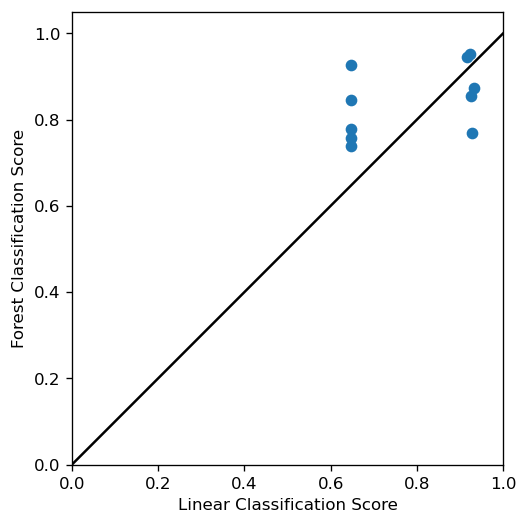

[('primary_genre_Foreign', 0.0),
 ('primary_genre_TV Movie', 0.0),
 ('secondary_genre_Western', 0.0),
 ('tertiary_genre_Documentary', 0.0),
 ('tertiary_genre_TV Movie', 0.0),
 ('tertiary_genre_Western', 0.0),
 ('primary_production_company_1492 Pictures', 0.0),
 ('primary_production_company_1818', 0.0),
 ('primary_production_company_19 Entertainment', 0.0),
 ('primary_production_company_21 Laps Entertainment', 0.0),
 ('primary_production_company_26 Films', 0.0),
 ('primary_production_company_3 Arts Entertainment', 0.0),
 ('primary_production_company_34th Street Films', 0.0),
 ('primary_production_company_360 Pictures', 0.0),
 ('primary_production_company_3D Entertainment', 0.0),
 ('primary_production_company_3L Filmproduktion GmbH', 0.0),
 ('primary_production_company_3Mark Entertainment', 0.0),
 ('primary_production_company_40 Acres & A Mule Filmworks', 0.0),
 ('primary_production_company_A B Corp', 0.0),
 ('primary_production_company_A Band Apart', 0.0),
 ('primary_production_company_

In [89]:
def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(y, predictions)

forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.figure(figsize=(5,5), facecolor='w', dpi=120)
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1.05) # increasing the limit a bit for proper visualization 
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# print the scores
print("Logistic Regression Scores:", logistic_regression_scores, "\nForest Classification Scores:", forest_classification_scores)

# Print the mean scores
print("Logistic Regression Score:", np.mean(logistic_regression_scores), "\nForest Classification Scores:", np.mean(forest_classification_scores))

# Show the plot.
plt.show()

# Print the importance of each covariate in the random forest classification.
forest_classifier.fit(covariates, classification_outcome)
sorted(list(zip(covariates, forest_classifier.feature_importances_)), key=lambda tup: tup[1])

In [98]:
X = df_movies_encoded.drop(columns=['revenue'])
y = df_movies_encoded['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train) 
training_score = knn.score(X_train.values, y_train.values) 
test_score = knn.score(X_test.values, y_test.values) 


/nfs/cms/mtech22/pekhale.sarang/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/cms/mtech22/pekhale.sarang/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [99]:
training_score

0.2055112881806109

In [100]:
test_score

0.10742705570291777